### Importing Relevant Packages

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set()

### Loading and Transforming the Data

In [9]:
raw_csv_data = pd.read_csv("data/Index2018.csv")
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, format = "%d/%m/%Y")
df_comp.set_index("date",inplace = True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

### Removing Surplus Data

In [10]:
df_comp['market_value'] = df_comp.spx
del df_comp['spx'],df_comp['dax'],df_comp['ftse'],df_comp['nikkei']
size = int(len(df_comp) * 0.8)
df,df_test = df_comp.iloc[:size],df_comp.iloc[size:]


### White Noise


White Noise is a time series, where every time point has a random value associated with it. There is no relationship between the past and present data, and, as a result, the future values cannot be predicted using past data. For a predictable time series, there has to be some relationship between the past and the future data, and the absence of such a relationship makes it impossible to predict future data using the past data. 

Mathematically, White Noise satisfiles the following 3 properties. 

* 1) Constant Mean. 
* 2) Constant Variance. 
* 3) No autocorrelation between any period.

Autocorrelation measures how correlated a series is with past versions of itself. 
No Autocorrelation means there is no clear relationship between past and present values.

In [12]:
wn = np.random.normal(loc = df.market_value.mean(), scale = df.market_value.std(), size = len(df))
df['wn'] = wn

C:\Users\Admin\AppData\Local\Temp/ipykernel_2676/2468947593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wn'] = wn


In [14]:
df.describe()

,market_value,wn
count,5021.000000,5021.000000
mean,1091.651926,1090.498791
std,292.559287,296.215626
min,438.920000,73.081982
25%,914.620000,888.700333
50%,1144.650000,1093.975322
75%,1316.280729,1288.275732
max,1570.252238,2191.726256


Note - The mean of the white noise is not exactly equal to the mean of the market_value. THis is due to the fact that the values are randomly drawn from the distribution that has the same mean as market_value. However, the individual points are randomly drawn and their mean may slightly differ from that of the distribution.

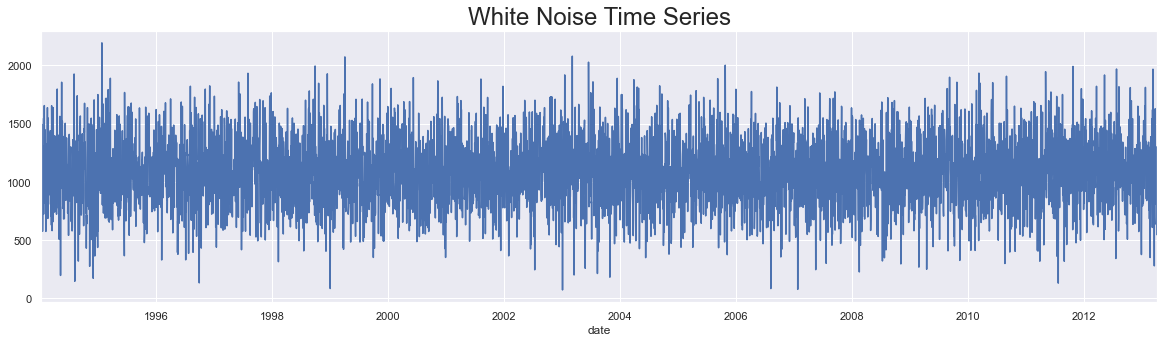

In [22]:
df.wn.plot(figsize=(20,5))
plt.title('White Noise Time Series',size = 24)
plt.show()

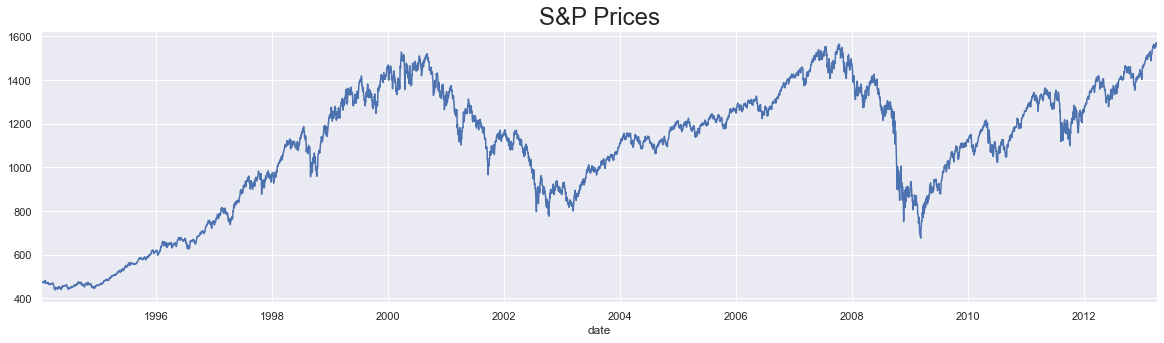

In [23]:
df.market_value.plot(figsize=(20,5))
plt.title('S&P Prices',size = 24)
plt.show()